In [1]:
!pip install datasets
!python setup.py install
import os
import torch
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch import nn, optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.transforms.functional import to_pil_image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import tensorflow_datasets as tfds
import timm
from IPython import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
python3: can't open file '/content/setup.py': [Errno 2] No such file or directory


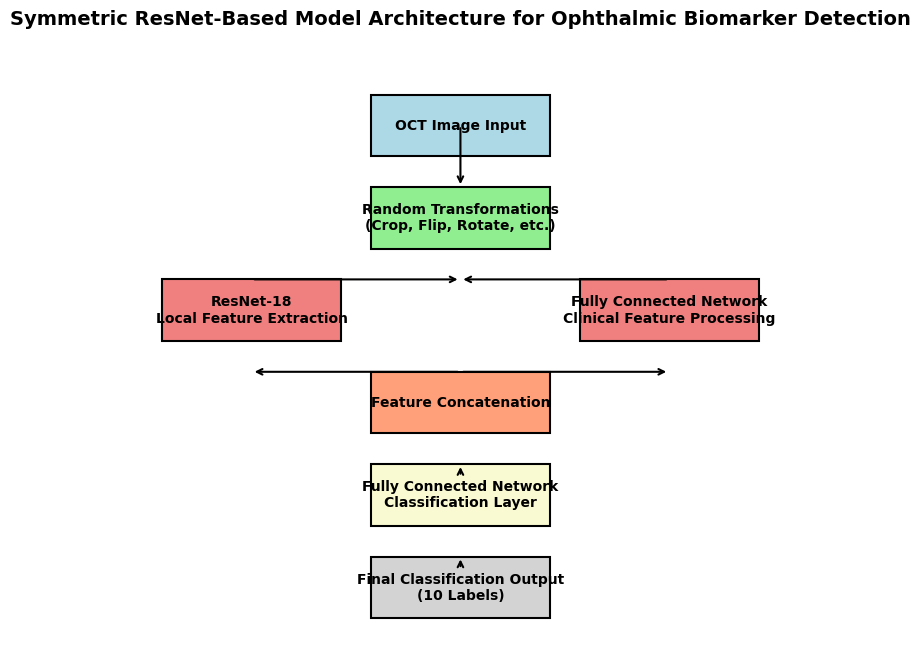

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Define rectangles representing different components of the architecture
components = [
    {"name": "OCT Image Input", "xy": (4, 8), "width": 3, "height": 1, "facecolor": "lightblue"},
    {"name": "Random Transformations\n(Crop, Flip, Rotate, etc.)", "xy": (4, 6.5), "width": 3, "height": 1, "facecolor": "lightgreen"},
    {"name": "ResNet-18\nLocal Feature Extraction", "xy": (0.5, 5), "width": 3, "height": 1, "facecolor": "lightcoral"},
    {"name": "Fully Connected Network\nClinical Feature Processing", "xy": (7.5, 5), "width": 3, "height": 1, "facecolor": "lightcoral"},
    {"name": "Feature Concatenation", "xy": (4, 3.5), "width": 3, "height": 1, "facecolor": "lightsalmon"},
    {"name": "Fully Connected Network\nClassification Layer", "xy": (4, 2), "width": 3, "height": 1, "facecolor": "lightgoldenrodyellow"},
    {"name": "Final Classification Output\n(10 Labels)", "xy": (4, 0.5), "width": 3, "height": 1, "facecolor": "lightgrey"}
]

# Draw rectangles
for component in components:
    rect = patches.Rectangle(
        component["xy"], component["width"], component["height"],
        linewidth=1.5, edgecolor='black', facecolor=component["facecolor"]
    )
    ax.add_patch(rect)
    ax.text(
        component["xy"][0] + component["width"] / 2, component["xy"][1] + component["height"] / 2,
        component["name"], ha='center', va='center', fontsize=10, fontweight='bold'
    )

# Draw arrows to indicate flow
arrows = [
    {"xy": (5.5, 7.5), "xytext": (5.5, 8.5)},  # From OCT Input to Transformations
    {"xy": (5.5, 6), "xytext": (2, 6)},        # From Transformations to ResNet-18
    {"xy": (5.5, 6), "xytext": (9, 6)},        # From Transformations to Clinical FC
    {"xy": (2, 4.5), "xytext": (5.5, 4.5)},    # From ResNet-18 to Concatenation
    {"xy": (9, 4.5), "xytext": (5.5, 4.5)},    # From Clinical FC to Concatenation
    {"xy": (5.5, 3), "xytext": (5.5, 2.8)},    # From Concatenation to Classification FC
    {"xy": (5.5, 1.5), "xytext": (5.5, 1.3)}   # From Classification FC to Output
]

for arrow in arrows:
    ax.annotate(
        "", xy=arrow["xy"], xytext=arrow["xytext"],
        arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5)
    )

# Set axis limits and labels
ax.set_xlim(-1, 12)
ax.set_ylim(0, 10)
ax.axis('off')  # Hide the axes

plt.title("Symmetric ResNet-Based Model Architecture for Ophthalmic Biomarker Detection", fontsize=14, fontweight='bold')
plt.show()


In [166]:
# Clone and setup MaxViT repository
!git clone https://github.com/google-research/maxvit
%cd /content/maxvit


# Import MaxViT layers and configurations
import maxvit.models.hparams as hparams
import maxvit.models.maxvit as layers


# Checkpoints location
CKPTS_DIRS = {
    'MaxViTTiny_i1k_224': 'gs://gresearch/maxvit/ckpts/maxvittiny/i1k/224',
    'MaxViTTiny_i1k_384': 'gs://gresearch/maxvit/ckpts/maxvittiny/i1k/384',
    'MaxViTTiny_i1k_512': 'gs://gresearch/maxvit/ckpts/maxvittiny/i1k/512',
    'MaxViTSmall_i1k_224': 'gs://gresearch/maxvit/ckpts/maxvitsmall/i1k/224',
    'MaxViTSmall_i1k_384': 'gs://gresearch/maxvit/ckpts/maxvitsmall/i1k/384',
    'MaxViTSmall_i1k_512': 'gs://gresearch/maxvit/ckpts/maxvitsmall/i1k/512',
    'MaxViTBase_i1k_224': 'gs://gresearch/maxvit/ckpts/maxvitbase/i1k/224',
    'MaxViTBase_i1k_384': 'gs://gresearch/maxvit/ckpts/maxvitbase/i1k/384',
    'MaxViTBase_i1k_512': 'gs://gresearch/maxvit/ckpts/maxvitbase/i1k/512',
    'MaxViTBase_i21k_i1k_224': None,
    'MaxViTBase_i21k_i1k_384': 'gs://gresearch/maxvit/ckpts/maxvitbase/i21k_i1k/384',
    'MaxViTBase_i21k_i1k_512': 'gs://gresearch/maxvit/ckpts/maxvitbase/i21k_i1k/512',
    'MaxViTLarge_i1k_224': 'gs://gresearch/maxvit/ckpts/maxvitlarge/i1k/224',
    'MaxViTLarge_i1k_384': 'gs://gresearch/maxvit/ckpts/maxvitlarge/i1k/384',
    'MaxViTLarge_i1k_512': 'gs://gresearch/maxvit/ckpts/maxvitlarge/i1k/512',
    'MaxViTLarge_i21k_i1k_224': None,
    'MaxViTLarge_i21k_i1k_384': 'gs://gresearch/maxvit/ckpts/maxvitlarge/i21k_i1k/384',
    'MaxViTLarge_i21k_i1k_512': 'gs://gresearch/maxvit/ckpts/maxvitlarge/i21k_i1k/512',
    'MaxViTXLarge_i21k_i1k_224': None,
    'MaxViTXLarge_i21k_i1k_384': 'gs://gresearch/maxvit/ckpts/maxvitxlarge/i21k_i1k/384',
    'MaxViTXLarge_i21k_i1k_512': 'gs://gresearch/maxvit/ckpts/maxvitxlarge/i21k_i1k/512',
}

fatal: destination path 'maxvit' already exists and is not an empty directory.
/content/maxvit


In [167]:

disease_train = load_dataset('gOLIVES/OLIVES_Dataset',
                      'disease_classification',
                      split='train',
                     )

print('finish loading disease dataset')

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

finish loading disease dataset


In [8]:
bio_test = load_dataset('gOLIVES/OLIVES_Dataset',
                      'biomarker_detection',
                      split='test',
                     )

print('finish loading bio_test')

bio_train = load_dataset('gOLIVES/OLIVES_Dataset',
                      'biomarker_detection',
                      split='train',
                     )

print('finish loading bio_train')

bio_test = bio_test.with_format("torch")
bio_train = bio_train.with_format("torch")

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

train-00000-of-00032.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00001-of-00032.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

train-00002-of-00032.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

train-00003-of-00032.parquet:   0%|          | 0.00/501M [00:00<?, ?B/s]

train-00004-of-00032.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

train-00005-of-00032.parquet:   0%|          | 0.00/491M [00:00<?, ?B/s]

train-00006-of-00032.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00007-of-00032.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

train-00008-of-00032.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

train-00009-of-00032.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

train-00010-of-00032.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00011-of-00032.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

train-00012-of-00032.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

train-00013-of-00032.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

train-00014-of-00032.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

train-00015-of-00032.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

train-00016-of-00032.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

train-00017-of-00032.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

train-00018-of-00032.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00019-of-00032.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

train-00020-of-00032.parquet:   0%|          | 0.00/492M [00:00<?, ?B/s]

train-00021-of-00032.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

train-00022-of-00032.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

train-00023-of-00032.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

train-00024-of-00032.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

train-00025-of-00032.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

train-00026-of-00032.parquet:   0%|          | 0.00/294M [00:00<?, ?B/s]

train-00027-of-00032.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00028-of-00032.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

train-00029-of-00032.parquet:   0%|          | 0.00/323M [00:00<?, ?B/s]

train-00030-of-00032.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

train-00031-of-00032.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

test-00000-of-00002.parquet:   0%|          | 0.00/430M [00:00<?, ?B/s]

test-00001-of-00002.parquet:   0%|          | 0.00/434M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3871 [00:00<?, ? examples/s]

finish loading bio_test


Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

finish loading bio_train


In [124]:
class EyeDataset(Dataset):
    def __init__(self, data, augmentation=None):
        self.data = data
        self.augmentation = augmentation

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        record = self.data[index]

        # Image processing
        img = to_pil_image(record['Image'].float())
        img = img.convert('RGB')  # Convert to grayscale
        if self.augmentation:
            img = self.augmentation(img)

        # Clinical information processing
        clinical_features = torch.tensor([
            record['BCVA'], record['CST'], record['Eye_ID'], record['Patient_ID'],
            record['B1'], record['B2'], record['B3'], record['B4'], record['B5'], record['B6']
        ], dtype=torch.float32)
        clinical_features = torch.nan_to_num(clinical_features, nan=0.0, posinf=0.0, neginf=0.0)

        # Feature normalization
        feature_mean = clinical_features.mean()
        feature_std = clinical_features.std() + 1e-8
        clinical_features = (clinical_features - feature_mean) / feature_std

        # Binary label conversion
        labels_binary = (clinical_features > 0.5).float()

        # Determine number of classes based on labels_binary length
        num_classes = len(labels_binary)

        return img, clinical_features, labels_binary, num_classes



# Image augmentation setup
# Change the image resize to (224, 224) or any size divisible by 7
image_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),  # 224 is divisible by 7
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Since the image is now RGB, mean and std for 3 channels
])





In [125]:
def compute_positive_weights(targets):
    target_counts = torch.tensor([sum(targets[:, i]) for i in range(targets.shape[1])])
    positive_weights = (targets.shape[0] - target_counts) / target_counts
    return positive_weights

In [126]:
def load_olives_datasets(augmentation):
    bio_train = load_dataset('gOLIVES/OLIVES_Dataset', 'biomarker_detection',
                             split='train')
    bio_train = bio_train.with_format("torch")

    train_dataset = EyeDataset(bio_train, augmentation=augmentation)

    print("Number of classes:", len(train_dataset[0][2]))  # This will print the number of labels

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
    return train_loader

train_loader = load_olives_datasets(image_augmentation)


Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

Number of classes: 10


In [127]:
def load_test_data(augmentation):
    bio_test_data = load_dataset('gOLIVES/OLIVES_Dataset', 'biomarker_detection',
                                 split='test')
    bio_test_data = bio_test_data.with_format("torch")

    test_dataset = EyeDataset(bio_test, augmentation=augmentation)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
    return test_loader


test_loader = load_test_data(image_augmentation)

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

In [128]:
class EVA02Model(nn.Module):
    def __init__(self, num_classes):
        super(EVA02Model, self).__init__()
        # Define layers (example: simple CNN-based architecture)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 32 * 32, num_classes)  # Adjust input size as needed

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [159]:
from maxvit.models.maxvit import MaxViT

class HybridEyeModel(nn.Module):
    def __init__(self):
        super(HybridEyeModel, self).__init__()

        # Local Feature Extraction with MaxViT
        model_name = "maxvit_tiny_rw_224"  # Replace with a model from timm.list_models('*maxvit*')  # Other options: maxvit_small, maxvit_large
        self.local_feature_extractor = timm.create_model(model_name, pretrained=True, num_classes=10)  # Adjust num_classes as needed

        # Global Feature Extraction with EVA-02
        self.global_feature_extractor = EVA02Model(num_classes=10)  # Using EVA-02 for global feature extraction

        # Clinical data fully connected network
        self.clinical_fc = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Combined fully connected network
        self.combined_fc = nn.Sequential(
            nn.Linear(128 + 128 + 32, 64),  # Combining local, global, and clinical features
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 10)  # 10 outputs for 10 labels
        )

    def forward(self, image, clinical_data):
    # Local Feature Extraction using MaxViT
      local_features = self.local_feature_extractor(image)
      local_features = torch.flatten(local_features, start_dim=1)
      print(f"Local features shape after flattening: {local_features.shape}")

    # Global Feature Extraction using EVA-02
      global_features = self.global_feature_extractor(image)
      global_features = torch.flatten(global_features, start_dim=1)
      print(f"Global features shape after flattening: {global_features.shape}")

    # Clinical Feature Extraction
      clinical_features = self.clinical_fc(clinical_data)
      print(f"Clinical features shape: {clinical_features.shape}")

    # Combine all features
      combined_features = torch.cat((local_features, global_features, clinical_features), dim=1)
      print(f"Combined features shape: {combined_features.shape}")

      output = self.combined_fc(combined_features)
      return output




In [160]:
training_metrics = {
    'accuracies': {
        'total': [],
        'B1': [], 'B2': [], 'B3': [], 'B4': [], 'B5': [], 'B6': []
    },
    'f1_scores': {
        'total': [],
        'B1': [], 'B2': [], 'B3': [], 'B4': [], 'B5': [], 'B6': []
    }
}

In [161]:
def calculate_metrics(predictions, targets):
    pred_labels = (torch.sigmoid(predictions) > 0.5).float()
    accuracies = []
    f1_scores = []

    for i in range(targets.shape[1]):
        acc = (pred_labels[:, i] == targets[:, i]).float().mean().item()
        true_positives = (pred_labels[:, i] * targets[:, i]).sum().item()
        pred_positives = pred_labels[:, i].sum().item()
        real_positives = targets[:, i].sum().item()

        precision = true_positives / (pred_positives + 1e-10)
        recall = true_positives / (real_positives + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

        accuracies.append(acc)
        f1_scores.append(f1)

    total_acc = sum(accuracies) / len(accuracies)
    total_f1 = sum(f1_scores) / len(f1_scores)

    return total_acc, accuracies, total_f1, f1_scores

In [162]:
def plot_training_metrics(metrics, current_epoch):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    epochs = range(len(metrics['accuracies']['total']))

    ax1.plot(epochs, metrics['accuracies']['total'],
             linewidth=2, label='Total Acc')
    for i in range(1, 7):
        ax1.plot(epochs, metrics['accuracies'][f'B{i}'],
                linestyle='--', label=f'B{i} Acc')

    ax1.set_ylim(0.3, 1.0)
    ax1.grid(True)
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Train VS Test Loss per Epoch')

    ax2.plot(epochs, metrics['f1_scores']['total'],
             linewidth=2, label='Total F1 Score')
    for i in range(1, 7):
        ax2.plot(epochs, metrics['f1_scores'][f'B{i}'],
                linestyle='--', label=f'B{i} F1 Score')

    ax2.set_ylim(0, 0.8)
    ax2.grid(True)
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('F1 Score')

    plt.tight_layout()
    plt.savefig(f'training_metrics_epoch_{current_epoch}.png', dpi=300, bbox_inches='tight')
    plt.close()


In [163]:
def train_eye_model(model, loader, loss_fn, optimizer, grad_scaler, epochs=10):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        epoch_outputs = []
        epoch_labels = []

        progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, clinical_data, labels, _ in progress_bar:
            images = images.to(device)
            clinical_data = clinical_data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images, clinical_data)
                loss = loss_fn(outputs, labels)

            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

            total_loss += loss.item()

            # Store batch outputs and labels for metric calculation
            epoch_outputs.append(outputs.detach().cpu())  # Move to CPU
            epoch_labels.append(labels.detach().cpu())    # Move to CPU

            progress_bar.set_postfix(loss=loss.item())

        # Calculate metrics for the epoch
        epoch_outputs = torch.cat(epoch_outputs)
        epoch_labels = torch.cat(epoch_labels)
        total_acc, accuracies, total_f1, f1_scores = calculate_metrics(epoch_outputs, epoch_labels)

        # Store metrics
        training_metrics['accuracies']['total'].append(total_acc)
        training_metrics['f1_scores']['total'].append(total_f1)
        for i in range(6):
            training_metrics['accuracies'][f'B{i+1}'].append(accuracies[i])
            training_metrics['f1_scores'][f'B{i+1}'].append(f1_scores[i])

        print(f"Epoch {epoch + 1}, Avg Loss: {total_loss / len(loader):.4f}, "
              f"Accuracy: {total_acc:.4f}, F1 Score: {total_f1:.4f}")

        # Plot metrics every N epochs or at the end
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            plot_training_metrics(training_metrics, epoch + 1)

    return training_metrics

In [164]:
# Set up device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridEyeModel().to(device)

# Set up loss function and optimizer
pos_weight = torch.ones(10).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()

# Train the model
train_eye_model(model, train_loader, criterion, optimizer, scaler)

# Save the model
torch.save(model.state_dict(), "hybrid_eye_model.pth")


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 6414 has 14.74 GiB memory in use. Of the allocated memory 14.29 GiB is allocated by PyTorch, and 329.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def evaluate_eye_model(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    epoch_outputs = []
    epoch_labels = []

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Evaluating", leave=False)
        for images, clinical_data, labels in progress_bar:
            images = images.to(device)
            clinical_data = clinical_data.to(device)
            labels = labels.to(device)

            outputs = model(images, clinical_data)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            # Store batch outputs and labels for metric calculation
            epoch_outputs.append(outputs.cpu())
            epoch_labels.append(labels.cpu())

            progress_bar.set_postfix(loss=loss.item())

    # Calculate metrics
    epoch_outputs = torch.cat(epoch_outputs)
    epoch_labels = torch.cat(epoch_labels)
    total_acc, accuracies, total_f1, f1_scores = calculate_metrics(epoch_outputs, epoch_labels)

    # Classification report
    pred_labels = (torch.sigmoid(epoch_outputs) > 0.5).int().numpy()
    true_labels = epoch_labels.int().numpy()
    report = classification_report(true_labels, pred_labels, target_names=[f'B{i+1}' for i in range(10)], zero_division=0)


    print(f"Evaluation Results - Avg Loss: {total_loss / len(loader):.4f}, "
          f"Accuracy: {total_acc:.4f}, F1 Score: {total_f1:.4f}\n")
    print(report)

    return total_acc, total_f1

In [ ]:
evaluate_eye_model(model, test_loader, criterion)

Evaluating:   0%|          | 0/242 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                                          

Evaluation Results - Avg Loss: 0.0919, Accuracy: 0.9779, F1 Score: 0.1799

              precision    recall  f1-score   support

          B1       1.00      0.67      0.80      2401
          B2       1.00      1.00      1.00      3871
          B3       0.00      0.00      0.00         0
          B4       0.00      0.00      0.00         0
          B5       0.00      0.00      0.00         0
          B6       0.00      0.00      0.00         0
          B7       0.00      0.00      0.00         0
          B8       0.00      0.00      0.00         0
          B9       0.00      0.00      0.00         0
         B10       0.00      0.00      0.00         0

   micro avg       0.99      0.87      0.93      6272
   macro avg       0.20      0.17      0.18      6272
weighted avg       1.00      0.87      0.92      6272
 samples avg       0.99      0.90      0.93      6272



(0.9778868496418, 0.17986006995521073)